In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 1- Import Data

Load the training data first, then check the data format

In [8]:
train_data = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
train_data.info()
print('-'*40)
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Passenger

<Axes: ylabel='count'>

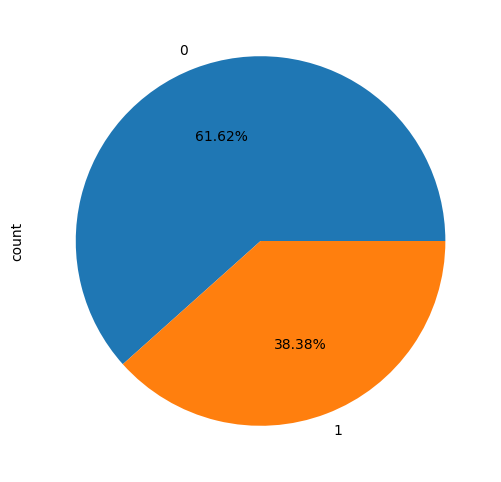

In [10]:
# First look at the overall survival ratio
fig = plt.figure(figsize=(6,6))
train_data['Survived'].value_counts().plot.pie(autopct = '%1.2f%%')

### 2-Missing value processing
When analyzing the data, it is important to note whether there are missing values in it.

Some machine learning algorithms can handle missing values, such as neural networks, and some cannot. For missing values, there are several general ways to handle them.

(1) If the dataset is large but has few missing values, the rows with missing values can be deleted.

(2) If the attribute is not very important relative to the learning, you can assign a mean or plurality to the missing values. For example, if the attribute Embarked (there are three embarkation locations) has two missing values, you can use the plural to assign the value



In [11]:
# Check for missing values in the 'Embarked' column
missing_embarked = train_data['Embarked'].isnull()

# Find the mode (most frequent value) of the 'Embarked' column
mode_embarked = train_data['Embarked'].mode()[0]

# Fill missing values with the mode
train_data['Embarked'].fillna(mode_embarked, inplace=True)

# Display the rows with missing 'Embarked' values before and after filling
print("Rows with missing 'Embarked' values before filling:")
print(train_data[missing_embarked])

# Verify that there are no more missing values in the 'Embarked' column
print("\nRows with missing 'Embarked' values after filling:")
print(train_data[train_data['Embarked'].isnull()])


Rows with missing 'Embarked' values before filling:
     PassengerId  Survived  Pclass                                       Name  \
61            62         1       1                        Icard, Miss. Amelie   
829          830         1       1  Stone, Mrs. George Nelson (Martha Evelyn)   

        Sex   Age  SibSp  Parch  Ticket  Fare Cabin Embarked  
61   female  38.0      0      0  113572  80.0   B28        S  
829  female  62.0      0      0  113572  80.0   B28        S  

Rows with missing 'Embarked' values after filling:
Empty DataFrame
Columns: [PassengerId, Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked]
Index: []


(3) For nominal attributes, you can assign a value that represents the absence, such as 'U0'. Because the absence itself may also represent some implicit information. For example, the missing property Cabin may mean that there is no cabin. 

In [13]:
# Fill missing values in the 'Cabin' column with 'U0'
train_data['Cabin'] = train_data['Cabin'].fillna('U0')

# Display the rows with missing 'Cabin' values before and after filling
print("Rows with missing 'Cabin' values before filling:")
print(train_data[train_data['Cabin'].isnull()])

# Verify that there are no more missing values in the 'Cabin' column
print("\nRows with missing 'Cabin' values after filling:")
print(train_data[train_data['Cabin'].isnull()])


Rows with missing 'Cabin' values before filling:
Empty DataFrame
Columns: [PassengerId, Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked]
Index: []

Rows with missing 'Cabin' values after filling:
Empty DataFrame
Columns: [PassengerId, Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked]
Index: []


(4) Use models such as regression Random Forest to predict the values of missing attributes. Since Age is a fairly important feature in this dataset (as can be seen by first analyzing Age), it is very important to ensure a certain accuracy in filling in the missing values, which can also have a large impact on the results. In general, entries with complete data are used as the training set for the model as a way to predict missing values. For this current data, either random forest can be used to predict or linear regression can be used to predict. Here the random forest prediction model is used, and the numerical attributes in the dataset are selected as features (because sklearn's model can only handle numerical attributes, so only numerical features are selected here first, but in practical applications non-numerical features need to be converted to numerical features)



In [14]:
from sklearn.ensemble import RandomForestRegressor

age_df = train_data[['Age','Survived','Fare', 'Parch', 'SibSp', 'Pclass']]
age_df_notnull = age_df.loc[(train_data['Age'].notnull())]
age_df_isnull = age_df.loc[(train_data['Age'].isnull())]
X = age_df_notnull.values[:,1:]
Y = age_df_notnull.values[:,0]
# use RandomForestRegression to train data
RFR = RandomForestRegressor(n_estimators=1000,n_jobs=-1)
RFR.fit(X,Y)
predictAges = RFR.predict(age_df_isnull.values[:,1:])
train_data.loc[train_data['Age'].isnull(), ['Age']]= predictAges

In [15]:
# Next, look at the complementary data
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        891 non-null    object 
 11  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# 3-Preliminary data analysis

#### 3-1-The relationship between gender and survival or not (Sex)

In [16]:
train_data.groupby(['Sex','Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

<Axes: xlabel='Sex'>

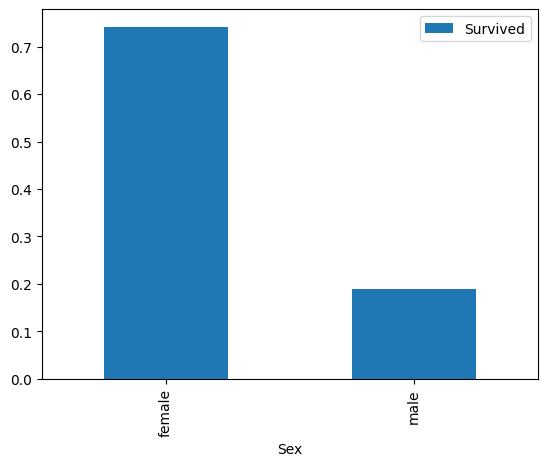

In [17]:
survived_by_sex = train_data[['Sex','Survived']].groupby('Sex').mean()
type(survived_by_sex)
survived_by_sex.plot.bar()

The above is the survival rate of different genders, which can be seen in the Titanic accident, or reflect the Lady First.

#### 3-2-The relationship between cabin class and survival or not Pclass

In [18]:
train_data.groupby(['Pclass','Survived'])['Pclass'].count()

Pclass  Survived
1       0            80
        1           136
2       0            97
        1            87
3       0           372
        1           119
Name: Pclass, dtype: int64

<Axes: xlabel='Pclass'>

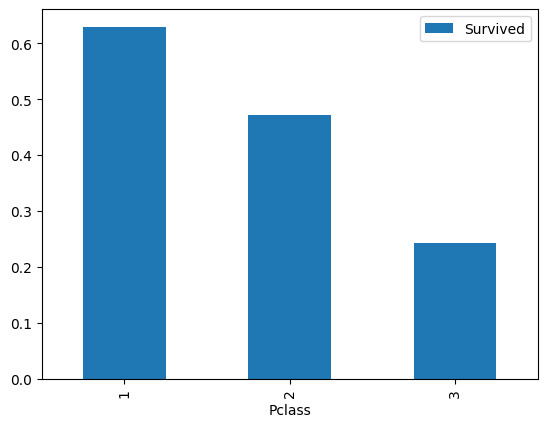

In [19]:
train_data[['Pclass','Survived']].groupby(['Pclass']).mean().plot.bar()

In [20]:
train_data.groupby(['Sex', 'Pclass', 'Survived'])['Survived'].count()

Sex     Pclass  Survived
female  1       0             3
                1            91
        2       0             6
                1            70
        3       0            72
                1            72
male    1       0            77
                1            45
        2       0            91
                1            17
        3       0           300
                1            47
Name: Survived, dtype: int64

<Axes: xlabel='Pclass,Sex'>

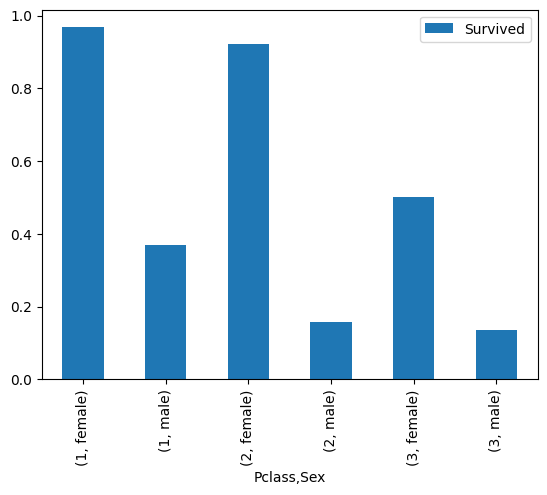

In [21]:
train_data[['Sex','Pclass','Survived']].groupby(['Pclass','Sex']).mean().plot.bar()

### 3-3 The relationship between age and survival

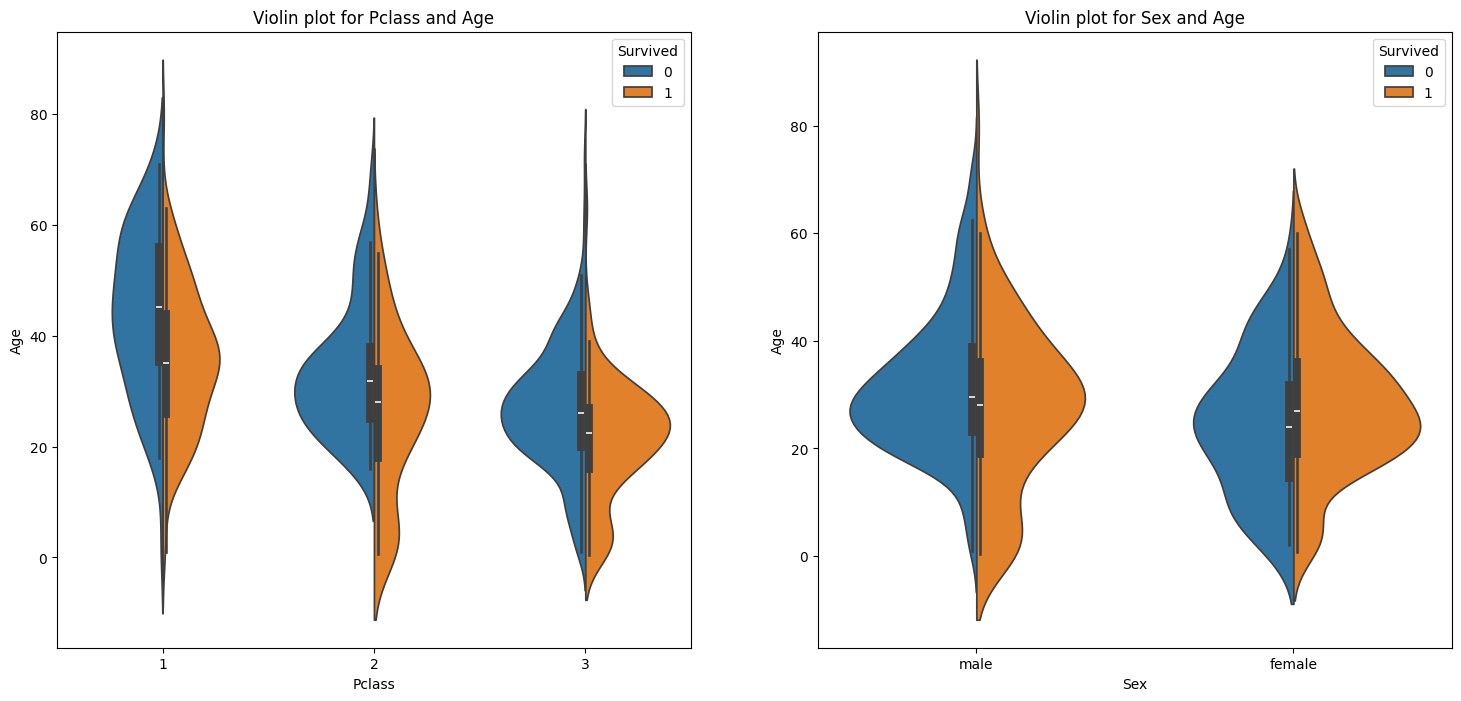

In [22]:

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

# Violin plot for 'Pclass' and 'Age'
sns.violinplot(x="Pclass", y="Age", hue="Survived", data=train_data, split=True, ax=ax[0])
ax[0].set_title('Violin plot for Pclass and Age')

# Violin plot for 'Sex' and 'Age'
sns.violinplot(x="Sex", y="Age", hue="Survived", data=train_data, split=True, ax=ax[1])
ax[1].set_title('Violin plot for Sex and Age')

# Show the plots
plt.show()


Analysis of the overall age distribution.

<Axes: >

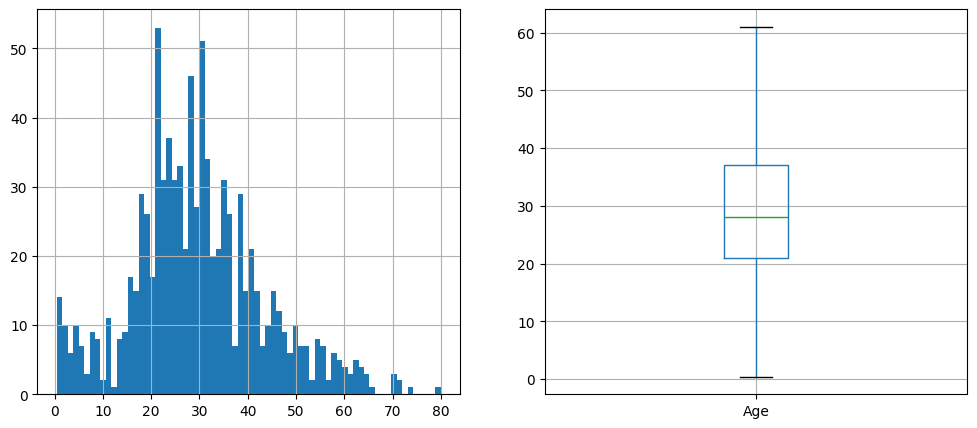

In [23]:
plt.figure(figsize=(12,5))
plt.subplot(121)
train_data['Age'].hist(bins=70)

plt.subplot(122)
train_data.boxplot(column='Age', showfliers=False)

Distribution of survival and non-survival at different ages.

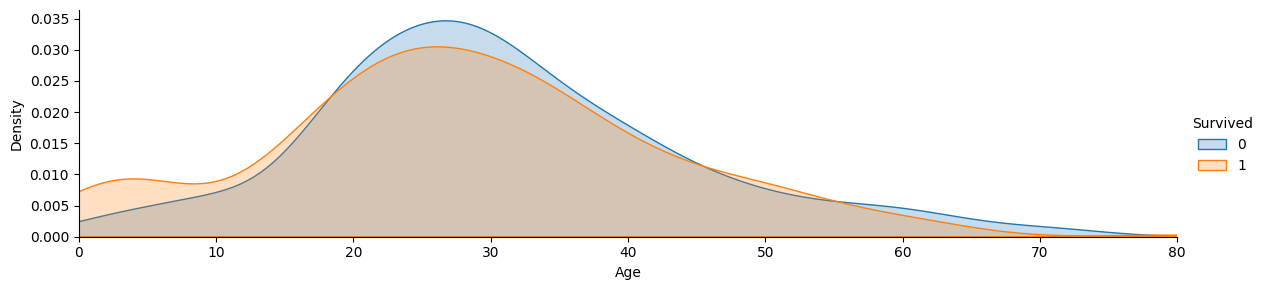

In [26]:
# Create FacetGrid
facet = sns.FacetGrid(train_data, hue='Survived', aspect=4)
facet.map(sns.kdeplot, 'Age', fill=True)
facet.set(xlim=(0, train_data['Age'].max()))

# Add legend
facet.add_legend()

# Show the plot
plt.show()